Let's import some libraries we'll use later on

In [1]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
from collections import defaultdict
import multiprocessing
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
pd.options.display.mpl_style = 'default'

def colors(index):
    """Define party colours"""
    from collections import defaultdict
    cm = defaultdict(lambda: 'w', {'Cons': '#0575c9', 'Labour': '#ed1e0e', 'UKIP': '#712f87',
         'SNP': '#ebc31c', 'Lib Dem': '#fe8300',
         'Green': '#78c31e', 'DUP': '#c0153d','Plaid Cymru': '#4e9f2f',
         'Sinn Fein': '#00623f', 'UUP': '#6ab1e6',
         'SDLP': '#65a966',
    })
    return [cm[party] for party in index]

aliases = { 'Conservative': 'Cons', 'Scottish National Party': 'SNP', 'Green Party': 'Green', 
    'Democratic Unionist Party': 'DUP', 'Ulster Unionist Party': 'UUP', 
    'Liberal Democrat': 'Lib Dem', 'Social Democratic & Labour Party': 'SDLP', 'Speaker': 'Cons',
    'Independent Sylvia Hermon': 'IND',
}

## The Data

#### Gathering Election Data

First thing's first we're going to need some data to work with. According to the Electoral Commision General Election 2015 website the BBC is the official source for this data. 

http://www.electoralcommission.org.uk/find-information-by-subject/elections-and-referendums/upcoming-elections-and-referendums/uk-parliamentary-general-election-2015

The BBC doesn't provide a raw format or API to get at this, so we'll use BeautifulSoup!

The first constituency, alphabetically, is Aberavon. The BBC has made their data accessible by the constituency GSS (Government Statistical Service ID), http://en.wikipedia.org/wiki/ONS_coding_system. The results from the bbc page for the Aberavon result can be found at: http://www.bbc.com/news/politics/constituencies/W07000049. 

*A note here is to be sure to  distinguish results from multiple independent candidates, as they do not stand for the same party. An example constituency is Blackpool South: http://www.bbc.com/news/politics/constituencies/E14000573.*

In [2]:
def constituency_results(constituency_id):
    r = requests.get("http://www.bbc.com/news/politics/constituencies/"+constituency_id)
    data = r.text
    soup = BeautifulSoup(data)
    name = soup.find('h1', class_='constituency-title__title').text
    result = soup.find('div', class_='election2015-results')
    parties = result.find_all('div', class_='party')
    data = []
    for party in parties:
        vote_text = party.find('li', class_='party__result--votes').text
        vote_count = int(vote_text.split()[0].replace(',', ''))
        party_name = party.find('div', class_='party__name--long').text
        if party_name == 'Independent':
            candidate_text = party.find('div', class_='party__result--candidate').text
            party_name += ' ' + candidate_text.replace(', with candidate ', '')
        data.append((vote_count, party_name))
    vote_counts, parties = zip(*data)
    return pd.Series(vote_counts, index=parties, name=constituency_id)

constituency_results('W07000049')

Labour                       15416
UKIP                          4971
Conservative                  3742
Plaid Cymru                   3663
Liberal Democrat              1397
Independent Captain Beany     1137
Green Party                    711
Socialist Labour Party         352
TUSC                           134
Name: W07000049, dtype: int64

#### Gathering Data for All Constituencies

To find all results, we'll need a list of every constituency. We expect 650 in total, the easiest way I found to get this was to get information for each candidate from https://yournextmp.com and take the set of unique gss_codes. This will prove useful later, when we start to do some mapping.

In [3]:
candidate_information = pd.DataFrame.from_csv('https://edit.yournextmp.com/media/candidates.csv')
candidate_information[:2]

,id,party,constituency,mapit_id,mapit_url,gss_code,twitter_username,facebook_page_url,party_ppc_page_url,gender,...,honorific_prefix,honorific_suffix,party_id,linkedin_url,elected,image_url,proxy_image_url_template,image_copyright,image_uploading_user,image_uploading_user_notes
name,,,,,,,,,,,,,,,,,,,,,
Captain Beany,20,Independent,Aberavon,66101,http://mapit.mysociety.org/area/66101,W07000049,captainbeany,https://www.facebook.com/VoteCaptainBeany,NaN,male,...,NaN,NaN,NaN,https://uk.linkedin.com/in/captainbeany,False,http://yournextmp.popit.mysociety.org/persons/...,http://yournextmp.popit.mysociety.org/image-pr...,public-domain,CaptainBeany,NaN
Peter Bush,6754,UK Independence Party (UKIP),Aberavon,66101,http://mapit.mysociety.org/area/66101,W07000049,NaN,https://www.facebook.com/peterbushukip,NaN,male,...,NaN,NaN,PP85,NaN,False,http://yournextmp.popit.mysociety.org/persons/...,http://yournextmp.popit.mysociety.org/image-pr...,public-domain,peter3,NaN


In [4]:
constituency_gss_codes = candidate_information.gss_code.unique()
len(constituency_gss_codes), constituency_gss_codes[:2]

(650, array(['W07000049', 'W07000058'], dtype=object))

There we can see the first constituency, Aberavon, W0700049. Back to the BBC to get information for each constituency. I'm going to use multiprocessing to do multiple URL requests in parallel, I think the BBC should be able to handle 650 queuries, no sweat.

In [5]:
pool = multiprocessing.Pool(25)
all_constituency_raw_data = pool.map(constituency_results, constituency_gss_codes)

Clean the data up a bit before we start to use it.
*Note: The seat of John Bercow, the Speaker, is considered non-partisan, but is included in the Conservative pool as it was originally won by the conservatives and John Vercow in 1997, so a vote for Bercow in Buckingham will be treated as a Conservative vote, this is the same treatment as the BBC*

In [6]:
all_constituency_dataframe = pd.concat(all_constituency_raw_data, axis=1)
speaker_is_conservative = pd.Index([aliases.get(p, p) for p in all_constituency_dataframe.index])
all_constituency_data = all_constituency_dataframe.groupby(speaker_is_conservative).sum()

## The result

#### First Past the Post

The 2015 UK General election was ran using a first past the post voting system (http://en.wikipedia.org/wiki/First-past-the-post_voting), also referred to as *the winner takes it all*. The party with the most votes wins the election in that constituency, let's see how the election turned out.

Based on the simple first past the post process, we can recreate the real result. This is how the seats are split between each party today.

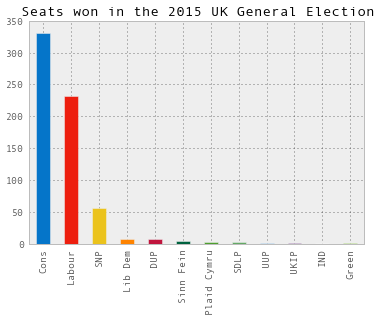

In [7]:
seats = all_constituency_data.idxmax(axis=0).value_counts()
seats.plot(kind='bar', title='Seats won in the 2015 UK General Election', color=colors(seats.index))

*Always the bridesmade and never the bride?*
The first past the post system does not reward second place, so a party can gain a lot of votes but win very few seats, which is what happened to the Greens and UKIP.

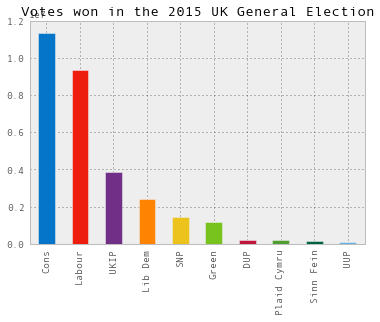

In [8]:
votes_per_party = all_constituency_data.sum(axis=1)
votes = votes_per_party.sort(ascending=False, inplace=False)[:10]
votes.plot(kind='bar', title='Votes won in the 2015 UK General Election', color=colors(votes.index))

##### The D'hondt System - Propotional Representation

The significant difference between the number of votes and the number of seats received by the parties has called into question the first past the post system. The Electoral Reform Society is campaigning for the use of the d'Hondt system, which attempts to proportionally allocate seats in a manner much more closely aligned to the number of votes a party receives accross the country. If used in the 2015 General Election we'd have had this result.

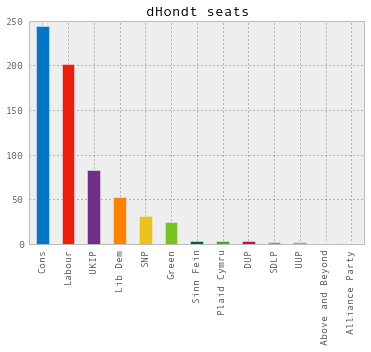

In [9]:
def dhondt(votes, total_seats):
    total_votes = votes.copy()
    seats = defaultdict(int)
    for seat in range(total_seats):
        winning_party = votes.index[0]
        seats[winning_party] +=1
        votes[0]=total_votes[winning_party]/(seats[winning_party]+1)
        votes.sort(ascending=False)
    return seats
dhondt_party_seats = dhondt(votes_per_party.copy(),650)
dhondt_seats = pd.Series([seats for party,seats in dhondt_party_seats.items()], index=[party for party,seats in dhondt_party_seats.items()])
dhondt_seats.sort(ascending=False)
dhondt_seats.plot(kind='bar', title='dHondt seats', color=colors(dhondt_seats.index))

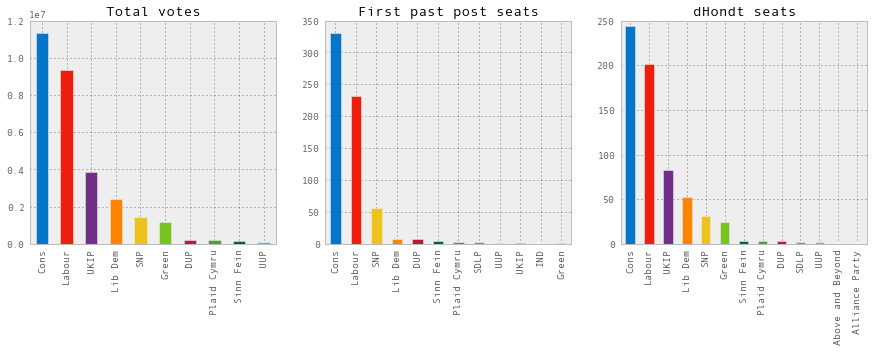

In [10]:
fig, axs = plt.subplots(1,3, figsize=(15,4))

votes.plot(ax=axs[0], kind='bar', title='Total votes', color=colors(votes.index))
seats.plot(ax=axs[1], kind='bar', title='First past post seats', color=colors(seats.index))
dhondt_seats.plot(ax=axs[2], kind='bar', title='dHondt seats', color=colors(dhondt_seats.index))

##### Power per vote

##### Power per vote geographically